# Alberi decisionali

Il 15 aprile del 1912, il Titanic ebbe una collisione con un iceberg e affondò. Morirono 1502 passeggeri su 2224 totali a bordo.

In questo laboratorio analizzeremo le caratteristiche delle persone che sopravvissero al disastro. In particolare, indurremo un albero decisionale dal dataset per predire quale passeggero sopravvisse alla tragedia.

Per prima cosa, importiamo le librerie necessarie

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Importiamo il dataset

In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
df = pd.read_csv("drive/MyDrive/Machine Learning 2023-2024/titanic.csv", sep=",")
print(f"Records: {df.shape[0]}")
print(f"Columns: {df.shape[1]}")

Records: 891
Columns: 12


In [4]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Analizziamo i tipi delle colonne e aggiustiamoli di conseguenza

In [5]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [6]:
df["Survived"] = df["Survived"].astype("category")
df["Pclass"] = df["Pclass"].astype("category")
df["Sex"] = df["Sex"].astype("category")
df["Embarked"] = df["Embarked"].astype("category")

In [7]:
df.dtypes

PassengerId       int64
Survived       category
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Ticket           object
Fare            float64
Cabin            object
Embarked       category
dtype: object

## Data exploration

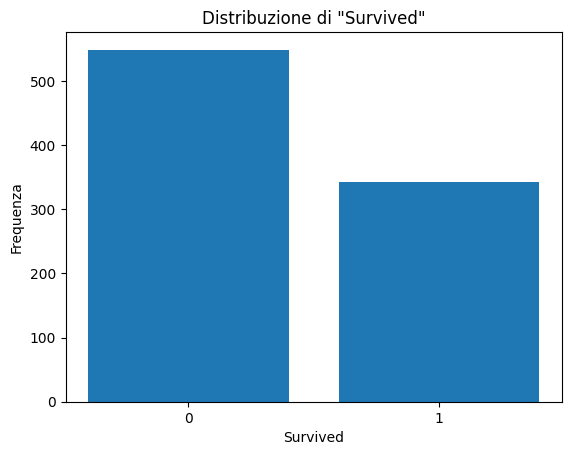

In [8]:
plt.bar(df["Survived"].unique(), df["Survived"].value_counts())
plt.xlabel("Survived")
plt.ylabel("Frequenza")
plt.title("Distribuzione di \"Survived\"")
plt.xticks([0, 1])
plt.show()

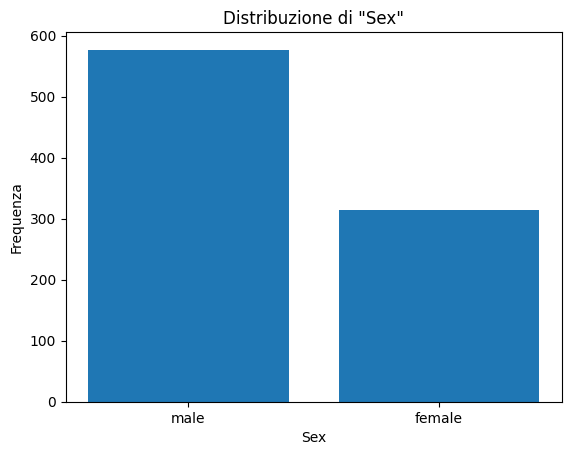

In [9]:
plt.bar(df["Sex"].unique(), df["Sex"].value_counts())
plt.xlabel("Sex")
plt.ylabel("Frequenza")
plt.title("Distribuzione di \"Sex\"")
plt.show()

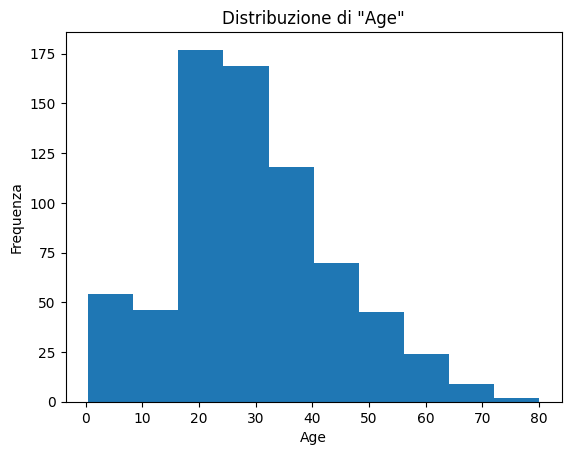

In [10]:
plt.hist(df["Age"])
plt.xlabel("Age")
plt.ylabel("Frequenza")
plt.title("Distribuzione di \"Age\"")
plt.show()

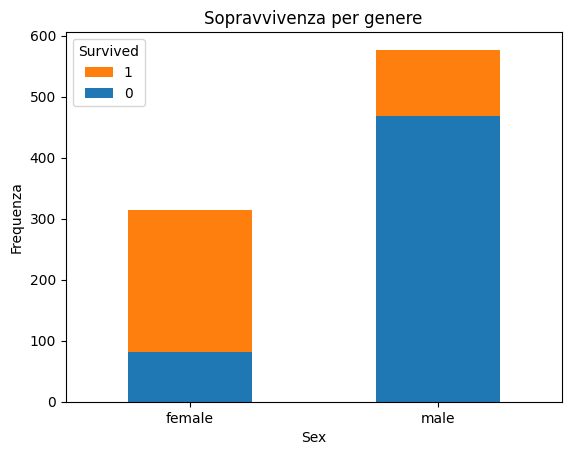

In [11]:
grouped = df.groupby(['Sex', 'Survived']).size().unstack()

# Creiamo il grafico a barre stackato
ax = grouped.plot(kind='bar', stacked=True)

ax.set_title('Sopravvivenza per genere')
ax.set_xlabel('Sex')
ax.set_ylabel('Frequenza')

# Rotazione delle labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Aggiungiamo una legenda
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], title='Survived')

plt.show()

## Creazione del training set e del test set

In [12]:
from sklearn.model_selection import train_test_split

feature_names = set(df.columns) - set(["Survived"])
target_name = "Survived"

X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df[target_name], test_size=0.3, random_state=42)

<ipython-input-12-f263e724873a>:6: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df[target_name], test_size=0.3, random_state=42)


In [13]:
print(f"Numero di record nel training set: {X_train.shape[0]}")
print(f"Numero di record nel test set: {X_test.shape[0]}")

Numero di record nel training set: 623
Numero di record nel test set: 268


## Modello di baseline

Vediamo nel training set, e nel test set, quante persone sono sopravvissute

In [14]:
y_train.value_counts() / y_train.count()

0    0.629213
1    0.370787
Name: Survived, dtype: float64

In [15]:
y_test.value_counts() / y_test.count()

0    0.585821
1    0.414179
Name: Survived, dtype: float64

Creiamo dunque un semplice classificatore che etichetta sempre positivamente le istanze, ossia per il modello tutti i passeggeri sopravvivono

In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix

# y_pred è un vettore di soli 1 (predizioni del modello di baseline)
y_pred = np.ones(y_test.shape)

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm)
print("\nAccuracy:", cm.diagonal().sum() / cm.sum())

Confusion matrix:
 [[  0 157]
 [  0 111]]

Accuracy: 0.4141791044776119


## Let's make a better model

Come abbiamo mostrato anche in precedenza con il grafico a barre, la maggioranza dei passeggeri sopravvissuti è di sesso femminile. Quindi il nuovo modello potrebbe basarsi su una differenza di sesso.

In [17]:
# predizione del nuovo modello
y_pred = (X_test["Sex"] == "female").astype(int)

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm)
print("\nAccuracy:", cm.diagonal().sum() / cm.sum())

Confusion matrix:
 [[134  23]
 [ 33  78]]

Accuracy: 0.7910447761194029


Notiamo che le performance sono migliorate

## Costruiamo un albero decisionale

Iniziamo a togliere le features che sicuramente non saranno utili in fase di training.

In [18]:
X_train.head()

,Parch,Name,Ticket,Sex,Cabin,PassengerId,Embarked,SibSp,Age,Pclass,Fare
445,2,"Dodge, Master. Washington",33638,male,A34,446,S,0,4.0,1,81.8583
650,0,"Mitkoff, Mr. Mito",349221,male,NaN,651,S,0,NaN,3,7.8958
172,1,"Johnson, Miss. Eleanor Ileen",347742,female,NaN,173,S,1,1.0,3,11.1333
450,2,"West, Mr. Edwy Arthur",C.A. 34651,male,NaN,451,S,1,36.0,2,27.7500
314,1,"Hart, Mr. Benjamin",F.C.C. 13529,male,NaN,315,S,1,43.0,2,26.2500


In [19]:
X_train = X_train.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)
X_test = X_test.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

In [20]:
X_train.head()

,Parch,Sex,Embarked,SibSp,Age,Pclass,Fare
445,2,male,S,0,4.0,1,81.8583
650,0,male,S,0,NaN,3,7.8958
172,1,female,S,1,1.0,3,11.1333
450,2,male,S,1,36.0,2,27.7500
314,1,male,S,1,43.0,2,26.2500


Dal momento che gli alberi decisionali nella libreria Sklearn impongono che le variabili siano numeriche, faremo una conversione delle variabili categoriche in numeriche.

In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
for col in ["Sex", "Embarked"]:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_test[col] = label_encoder.transform(X_test[col])

In [22]:
X_train.head()

,Parch,Sex,Embarked,SibSp,Age,Pclass,Fare
445,2,1,2,0,4.0,1,81.8583
650,0,1,2,0,NaN,3,7.8958
172,1,0,2,1,1.0,3,11.1333
450,2,1,2,1,36.0,2,27.7500
314,1,1,2,1,43.0,2,26.2500


Rimpiazziamo i valori nulli d'età con la media d'età

In [23]:
eta_media = X_train["Age"].mean()
X_train["Age"] = X_train["Age"].fillna(eta_media)
X_test["Age"] = X_test["Age"].fillna(eta_media)
X_train.head()

,Parch,Sex,Embarked,SibSp,Age,Pclass,Fare
445,2,1,2,0,4.000000,1,81.8583
650,0,1,2,0,29.256353,3,7.8958
172,1,0,2,1,1.000000,3,11.1333
450,2,1,2,1,36.000000,2,27.7500
314,1,1,2,1,43.000000,2,26.2500


Convertiamo tutte le colonne a numeriche

In [24]:
X_train.dtypes

Parch          int64
Sex            int64
Embarked       int64
SibSp          int64
Age          float64
Pclass      category
Fare         float64
dtype: object

In [25]:
#X_train["Fare"] = X_train["Fare"].apply(lambda x: x.replace(".", "")) # i punti separano di 3 in 3 le cifre. togliamoli per questioni tecniche
#X_test["Fare"] = X_test["Fare"].apply(lambda x: x.replace(".", ""))

for col in X_train.columns:
  X_train[col] = X_train[col].astype(int)
  X_test[col] = X_test[col].astype(int)

In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Visualizza l'albero decisionale
fig, ax = plt.subplots(figsize=(150, 100))
plot_tree(model, filled=True, ax=ax)
plt.plot()

Output hidden; open in https://colab.research.google.com to view.

## Inferenza

In [27]:
# predizione del nuovo modello
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Confusion matrix:\n", cm)
print("\nAccuracy:", cm.diagonal().sum() / cm.sum())

Confusion matrix:
 [[128  29]
 [ 29  82]]

Accuracy: 0.7835820895522388


## Parametro di complessità

Vediamo come varia l'accuratezza dell'albero decizionale in funzione della complessità dell'albero

In [28]:
path = model.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas

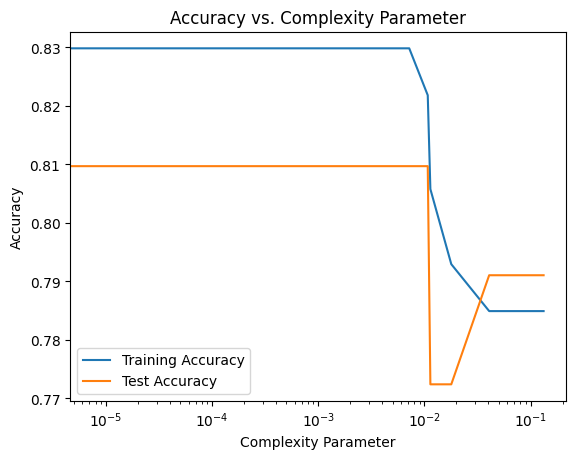

In [29]:
#complexity_values = [0.001, 0.01, 0.1, 1, 10, 100]
ccp_alphas = path.ccp_alphas

# Addestra l'albero decisionale con diversi valori di complessità
train_accuracy = []
test_accuracy = []
for complexity in ccp_alphas:
    clf = DecisionTreeClassifier(max_depth=3, ccp_alpha=complexity)
    clf.fit(X_train, y_train)
    train_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))

# Plotta l'accuratezza del modello in funzione del parametro di complessità
plt.plot(ccp_alphas, train_accuracy, label='Training Accuracy')
plt.plot(ccp_alphas, test_accuracy, label='Test Accuracy')
plt.xlabel('Complexity Parameter')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Complexity Parameter')
plt.xscale('log')
plt.legend()
plt.show()

In [30]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 3 with ccp_alpha: 0.13235809539273607


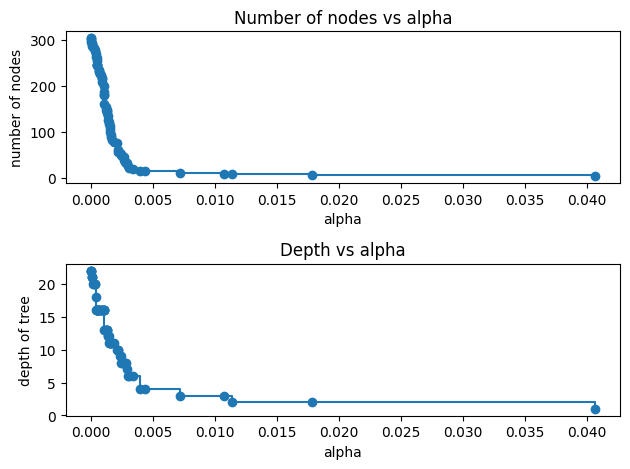

In [31]:
clfs = clfs[:-1]
complexity_values = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(complexity_values, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(complexity_values, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

## Assignment

1. Disegnare gli alberi tagliati in accordo al parametro di complessità
2. Provate a creare  altri alberi modificando i parametri nel costruttore DecisionTreeClassifier(). Ad esempio, cosa succede se si cambiano i criteri di splitting? Come varia l'accuratezza? Cosa succede all'aumentare della max_depth?